In [235]:
import numpy as np
import itertools

import jax
import jax.numpy as jnp

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

path_ = os.path.abspath(os.path.join('..', '00_utils'))

if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_models'))

if path_ not in sys.path:
    sys.path.append(path_)

from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
import collocation_obj

import run_train_toy

In [2]:
import logging
logging.basicConfig(level=logging.ERROR, filename='error_log.txt')

In [3]:
importlib.reload(collocation_obj)
Collocation = collocation_obj.Collocation

### Set Out Hyperparameter Optimization (Shared Parameters)
* network size
* regularization
* number of training points

### Pyomo-specific Hyperparameters
* number of collocation points with fixed n. of training points
* objective tolerances

### Sequential ODE Solver Hyperparameters
* learning rate
* number of training epochs
* ODE-solver tolerances


---
# Generate Data

In [344]:
importlib.reload(run_train_toy)
TrainerToy = run_train_toy.TrainerToy

def load_trainer(type_, spacing_type="chebyshev"):
    data_params_ho = {
        'N': 200,
        'noise_level': 0.2,
        'ode_type': "harmonic_oscillator",
        'data_param': {"omega_squared": 2},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0])
    }

    data_params_vdp = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "van_der_pol",
        'data_param': {"mu": 1, "omega": 1},
        'start_time': 0,
        'end_time': 15,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0])
    }

    data_params_do = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "damped_oscillation",
        'data_param': {"damping_factor": 0.1, "omega_squared": 1},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0])
    }

    if type_ == "ho":
        p_ = data_params_ho
    elif type_ == "vdp":
        p_ = data_params_vdp
    elif type_ == "do":
        p_ = data_params_do
    else:
        raise ValueError(f"Invalid type {type_}")

    trainer = TrainerToy(p_, model_type="pyomo")
    trainer.prepare_inputs()
    return trainer

## Network Size

####  Netwrok Sizes to be tested:
[2, 16, 2] <br>
[2, 32, 2] <br>
[2, 64, 2] <br>
[2, 16, 16, 2] <br>
[2, 32, 32, 2] <br>
[2, 64, 64, 2] <br>

Parameters to vary:
* Tolerance (pyomo) and epochs (sequential ODE solver)
* Regularizarion

In [279]:
reg_list = [0.001, 0.01, 0.1]
tol_list = [1e-6, 1e-7, 1e-8]

param_combinations = list(itertools.product(reg_list, tol_list))

for c in param_combinations:
    print(str(c))
    print("Regularization:", c[0], "Tolerance:", c[1])

(0.001, 1e-06)
Regularization: 0.001 Tolerance: 1e-06
(0.001, 1e-07)
Regularization: 0.001 Tolerance: 1e-07
(0.001, 1e-08)
Regularization: 0.001 Tolerance: 1e-08
(0.01, 1e-06)
Regularization: 0.01 Tolerance: 1e-06
(0.01, 1e-07)
Regularization: 0.01 Tolerance: 1e-07
(0.01, 1e-08)
Regularization: 0.01 Tolerance: 1e-08
(0.1, 1e-06)
Regularization: 0.1 Tolerance: 1e-06
(0.1, 1e-07)
Regularization: 0.1 Tolerance: 1e-07
(0.1, 1e-08)
Regularization: 0.1 Tolerance: 1e-08


In [224]:
tol = 1e-7
params_model = {
    'layer_widths': [2, 16, 2],
    'act_func': 'tanh',
    'penalty_lambda_reg': 0.01,
    'time_invariant': True,
    'w_init_method': 'xavier',
    'params': 
            {
          "tol":1e-7, 
          #"dual_inf_tol": tol, 
          #"compl_inf_tol": tol,
          #"constr_viol_tol": tol, 
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0,    
          "halt_on_ampl_error" : 'yes',
          "print_level": 1, 
          "max_iter": 3000}
}

results = {}

lw_list = [[2, 4, 2], [2, 8, 2],[2, 16, 2], [2, 32, 2], [2, 64, 2], [2, 128, 2], [2, 8, 8, 2], [2, 16, 16, 2]]

total_iter = len(param_combinations)*len(lw_list)
i = 1

for lw in lw_list:
    params_model['layer_widths'] = lw
    results[str(lw)] = {}
    
    for param_comb in param_combinations:
      params_model['penalty_lambda_reg'] = param_comb[0]
      params_model['params']['tol'] = param_comb[1]
      
      try:
        trainer.train_pyomo(params_model)
      except Exception as e:
        logging.error("Failed to complete training: {}".format(e))
        continue
      
      try:
        result = trainer.extract_results_pyomo()
        results[str(lw)][str(param_comb)] = result
      except XlaRuntimeError as e:
        logging.error("An XlaRuntimeError occurred: {}".format(e))
        print(f"Error during result extraction: {e}")
      
      print("Iteration:", i, "/", total_iter)
      i+=1

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.1164782047271729, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 1 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.0297002792358398, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 2 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 0.95961594581604, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 3 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.1058120727539062, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 4 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2296359539031982, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 5 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.551253080368042, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 6 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.3479790687561035, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 7 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.200070858001709, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 8 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.216944932937622, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 9 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.0490832328796387, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 10 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2136204242706299, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 11 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2444911003112793, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 12 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.6494567394256592, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 13 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.3762328624725342, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 14 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.4347000122070312, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 15 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.3719580173492432, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 16 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.5581772327423096, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 17 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.1906850337982178, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 18 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2500429153442383, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 19 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.131343126296997, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 20 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2001841068267822, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 21 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2457759380340576, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 22 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2612249851226807, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 23 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.2513830661773682, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 24 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.755439043045044, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 25 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.8323869705200195, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 26 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.737339973449707, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 27 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.708747148513794, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 28 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.1688108444213867, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 29 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.871001958847046, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 30 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.7844462394714355, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 31 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.3312320709228516, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 32 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.9427037239074707, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 33 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.8498420715332031, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 34 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.4512829780578613, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 35 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.4365670680999756, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 36 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.535449743270874, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 37 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.527387857437134, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 38 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.4827587604522705, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 39 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.475714921951294, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 40 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.547722339630127, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 41 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 3.1035828590393066, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 42 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 3.1742947101593018, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 43 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 3.2617170810699463, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 44 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.9469449520111084, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 45 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.0550332069396973, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 46 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 2.8635191917419434, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 47 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 1.958510160446167, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 48 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 13.946074962615967, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 49 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 14.83895492553711, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 50 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 14.800615787506104, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 51 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 14.077147960662842, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 52 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 5.221491098403931, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 53 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 5.516206979751587, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 54 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 4.861241102218628, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 55 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 5.088352918624878, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 56 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 4.435311794281006, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 57 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 6.827018976211548, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 58 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 6.460721969604492, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 59 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 7.497087001800537, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 60 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 51.396594762802124, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 61 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 50.558921098709106, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 62 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 50.350651025772095, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 63 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 50.979535818099976, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 64 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 30.66110110282898, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 65 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 30.70280122756958, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 66 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 57.077361822128296, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 67 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 49.744163036346436, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 68 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 21.891674041748047, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 69 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 35.60764169692993, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 70 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 48.949098110198975, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 71 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 50.659348011016846, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 72 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 361.28394889831543, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 73 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 378.6384379863739, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 74 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 384.7202308177948, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 75 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 461.2948319911957, 'termination_condition': <TerminationCondition.maxIterations: 'maxIterations'>, 'message': 'Ipopt 3.14.16\\x3a Maximum Number of Iterations Exceeded.'}
Iteration: 76 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 129.10185289382935, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Iteration: 77 / 96


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:82: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-06
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Ipopt 3.14.16: tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source 

KeyboardInterrupt: 

In [236]:
# box plots of accuracy and time elapsed for each layer width
# x axis: layer width
acc = []
time = []

for lw in results.keys():
    acc_temp = []
    time_temp = []
    for param_comb in results[lw].keys():
        acc_temp.append(results[lw][param_comb]['mse_test'].item())
        time_temp.append(results[lw][param_comb]['time_elapsed'])
        
    acc.append(acc_temp)
    time.append(time_temp)
    
plt.figure(figsize=(10, 6))
plt.boxplot(time)

plt.title('Boxplot of Training Time (sec) for different model sizes')
plt.xlabel('Model Configuration')
plt.ylabel('Training Time (s)')

labels = list(results.keys())
ticks = range(1, len(labels) + 1)
plt.xticks(ticks=ticks, labels=labels)

plt.yscale('log')
plt.show()

In [228]:
with open('pyomo_results.pkl', 'wb') as file:
    pickle.dump(results, file)

#### Regularization [X]
#### Pre-initalization [X]
#### Tolerances [X]
#### Network Sizes []

In [236]:
tol_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
param_combinations = list(itertools.product(tol_list, tol_list))

In [345]:
trainer_ch = load_trainer("vdp")
print('-----')
trainer_gl = load_trainer("vdp", 'gauss_legendre')

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


-----


/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/scipy/special/_orthogonal.py:2504: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [346]:
print(trainer_ch.y[:5])
print(trainer_ch.t[:5])
print('---------------')
print(trainer_gl.y[:5])
print(trainer_gl.t[:5])

[[0.00000000e+00 1.00000000e+00]
 [9.35452191e-04 1.00186959e+00]
 [3.75206348e-03 1.00748311e+00]
 [8.48063331e-03 1.01685458e+00]
 [1.51726068e-02 1.03000663e+00]]
[0.         0.00093458 0.00373808 0.00840981 0.0149486 ]
---------------
[[0.         1.        ]
 [0.0023081  1.00460824]
 [0.0064867  1.01291082]
 [0.01258161 1.02492959]
 [0.02065795 1.04069243]]
[0.00053947 0.00284227 0.00698459 0.01296633 0.02078614]


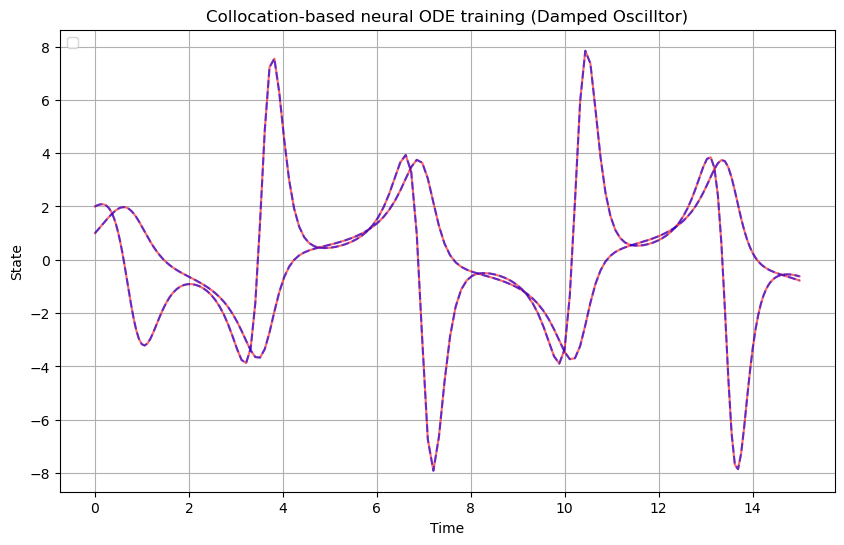

In [350]:
k = 200
D = trainer_ch.D

dy_dt_0 = []
dy_dt_1 = []

for i in range(len(trainer_ch.t)):
    dy_dt = (D[i] @ trainer_ch.y)
    dy_dt_0.append(dy_dt[0])
    dy_dt_1.append(dy_dt[1])
    
plt.figure(figsize=(10, 6))

#plt.plot(trainer_ch.t, trainer_ch.y[:,0], color = 'blue', label='True Data (Train)', alpha = 0.6)
#plt.plot(trainer_ch.t, trainer_ch.y[:,1], color = 'blue', alpha = 0.6)
plt.plot(trainer_ch.t[:k], dy_dt_0[:k], color = 'red', alpha = 0.6)
plt.plot(trainer_ch.t[:k], dy_dt_1[:k], color = 'red', alpha = 0.6)
plt.plot(trainer_ch.t, trainer_ch.true_derivative, '--', color = 'blue', alpha = 0.6)

plt.title(f"Collocation-based neural ODE training (Damped Oscilltor)")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

In [333]:
D = trainer_gl.D

dy_dt_0 = []
dy_dt_1 = []

for i in range(len(trainer_gl.t)):
    dy_dt = (D[i] @ trainer_gl.y)
    dy_dt_0.append(dy_dt[0])
    dy_dt_1.append(dy_dt[1])

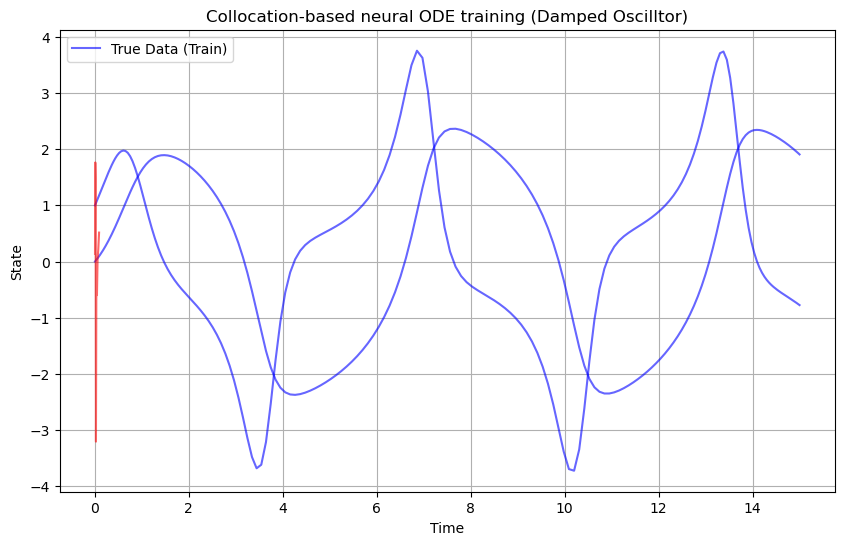

In [336]:
plt.figure(figsize=(10, 6))

plt.plot(trainer_gl.t, trainer_gl.y[:,0], color = 'blue', label='True Data (Train)', alpha = 0.6)
plt.plot(trainer_gl.t, trainer_gl.y[:,1], color = 'blue', alpha = 0.6)
plt.plot(trainer_gl.t[:10], dy_dt_0[:10], color = 'red', alpha = 0.6)

plt.title(f"Collocation-based neural ODE training (Damped Oscilltor)")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

In [313]:
tol = 1e-8
params_model = {
    'layer_widths': [2, 16, 2],
    'act_func': 'tanh',
    'penalty_lambda_reg': 0.001,
    'time_invariant': True,
    'w_init_method': 'xavier',
    "reg_norm": False,
    'params': 
            {
          "tol":tol, 
          #"dual_inf_tol": tol, 
          #"compl_inf_tol": tol,
          "constr_viol_tol": 1e-4, 
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0,    
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          "max_iter": 3000}}

RESULTS = {}

tol_list = [1, 1e-2, 1e-4, 1e-6, 1e-8]
param_combinations = list(itertools.product(tol_list, tol_list))

# param_combinations = [[2, 4, 2], [2,8,2], [2,16,2], [2,32,2], [2,64,2], [2,128,2]]
total_iter = len(param_combinations)
i = 1
    
for param_comb in [0]:
    # PARAMETER UPDATE
    # params_model['params']['tol'] = param_comb[0]
    # params_model['params']['constr_viol_tol'] = param_comb[1]
    
    try:
      trainer_ch.train_pyomo(params_model)
    except Exception as e:
      logging.error("Failed to complete training: {}".format(e))
      print(f"{e}")
      continue
    
    try:
      RESULTS[param_comb] = trainer_ch.extract_results_pyomo()
    except Exception as e:
      logging.error("Failed to extract results: {}".format(e))
      print(f"{e}")
    
    print("Iteration:", i, "/", total_iter)
    i+=1

current_14_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:85: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: tol=1e-08
constr_viol_tol=0.0001
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower boun

In [314]:
RESULTS

{0: {'time_elapsed': 4.345112085342407,
  'direct_model_pred': [array([ 0.04586442,  0.04636315,  0.04801338,  0.05071119,  0.05466156,
           0.05981228,  0.06642235,  0.07449487,  0.08434767,  0.09604374,
           0.10996465,  0.12623687,  0.14530801,  0.16736677,  0.19292187,
           0.22221291,  0.25579161,  0.29392092,  0.33715897,  0.38574488,
           0.44018696,  0.50063483,  0.56747355,  0.6406801 ,  0.72042014,
           0.80637702,  0.89832417,  0.99536716,  1.0963817 ,  1.19905742,
           1.3002915 ,  1.39569349,  1.48112415,  1.55333495,  1.61161614,
           1.65707269,  1.6921776 ,  1.7186086 ,  1.73743687,  1.74880265,
           1.75313082,  1.75061286,  1.74192107,  1.72737953,  1.70764138,
           1.68286613,  1.65347829,  1.61933903,  1.5805506 ,  1.53657732,
           1.48706838,  1.43089308,  1.36696138,  1.29314066,  1.20707815,
           1.10504841,  0.98301594,  0.83597878,  0.6602837 ,  0.4540967 ,
           0.21909342, -0.04286319, -0.

In [277]:
reload = True
if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/{formatted_time}_network_sizes.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(RESULTS, file)